In [1]:
import os
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
from utils.tools import dotdict
import pandas as pd
import matplotlib.pyplot as plt
from data_provider.data_factory import data_provider
from data_provider.data_loader import Dataset_Pred

import os
import datetime
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
args = dotdict()
args.target = 'e_mu_current'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False

args.freq = 't'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './datasets/'
# args.data_path ='non_outliers_step=120_log_inf_train=0.9.csv' 
args.data_path ='outliers_step=120_log_inf_train=0.9.csv'
args.model_id='qber_96_48_120_loginf_s_outliers'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 1
args.e_layers = 6
args.d_layers = 6
args.n_heads = 8
args.factor = 3
args.enc_in = 6
args.dec_in =6
args.c_out = 6
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = False
args.output_attention = True
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 64
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 10

exp = Exp_Main(args)

Use GPU: cuda:0


In [3]:
setting='qber_96_48_120_loginf_t_outliers_Autoformer_custom_ftMS_sl96_ll48_pl1_dm512_nh8_el6_dl6_df2048_fc1_ebtimeF_dtFalse_Exp_0'

best_model_path=f'./checkpoints/{setting}/checkpoint.pth'

exp.model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [5]:
dataset, pred_loader=data_provider(args, flag='pred')

for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
    pass

print(batch_x.shape)
print(batch_y.shape)
print(batch_x_mark.shape)
print(batch_y_mark.shape)

pred 1
torch.Size([1, 96, 6])
torch.Size([1, 48, 6])
torch.Size([1, 96, 5])
torch.Size([1, 49, 5])


In [ ]:
exp._predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

In [40]:
def preprocess_autoformer(df_raw, seq_len, label_len,target='e_mu_current',freq='t'):
    pred_len=1

    cols = list(df_raw.columns)
    cols.remove(target)
    cols.remove('date')

    df_raw = df_raw[['date'] + cols + [target]]
    border1 = len(df_raw) - seq_len - 1
    border2 = len(df_raw)

    cols_data = df_raw.columns[1:]
    df_data = df_raw[cols_data]

    data = df_data.values

    tmp_stamp = df_raw[['date']][border1:border2]
    tmp_stamp['date'] = pd.to_datetime(tmp_stamp.date)
    pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=pred_len + 1, freq=freq)

    df_stamp = pd.DataFrame(columns=['date'])
    df_stamp.date = list(tmp_stamp.date.values) + list(pred_dates[1:])

    df_stamp = df_raw[['date']][border1:border2]
    df_stamp['date'] = pd.to_datetime(df_stamp.date)

    df_stamp['month'] = df_stamp.date.apply(lambda row: row.month, 1)
    df_stamp['day'] = df_stamp.date.apply(lambda row: row.day, 1)
    df_stamp['weekday'] = df_stamp.date.apply(lambda row: row.weekday(), 1)
    df_stamp['hour'] = df_stamp.date.apply(lambda row: row.hour, 1)
    df_stamp['minute'] = df_stamp.date.apply(lambda row: row.minute, 1)
    df_stamp['minute'] = df_stamp.minute.map(lambda x: x // 15)
    data_stamp = df_stamp.drop(['date'], axis=1).values

    data_x = data[border1:border2]
    data_y = data[border1:border2]

    s_begin = 0
    s_end = s_begin + seq_len
    r_begin = s_end - label_len
    r_end = r_begin + label_len + pred_len

    seq_x = data_x[s_begin:s_end]
    seq_y = data_y[r_begin:r_begin + label_len]
    seq_x_mark = data_stamp[s_begin:s_end]
    seq_y_mark = data_stamp[r_begin:r_end+1]

    
    return seq_x, seq_y, seq_x_mark, seq_y_mark

In [41]:
df=pd.read_csv('datasets/data_step=60_test=0.1.csv')

In [46]:
exp.model.eval()

preds = []
trues = []

with torch.no_grad():
    for i  in tqdm(range(len(df)-args.seq_len)):
        
        df_tmp=df.iloc[i:i+args.seq_len+10]

        seq_x, seq_y, seq_x_mark, seq_y_mark=preprocess_autoformer(df_tmp,args.seq_len, args.label_len )
        
        batch_x = torch.FloatTensor(seq_x).unsqueeze(0).to(exp.device)
        batch_y = torch.FloatTensor(seq_y).unsqueeze(0).to(exp.device)

        batch_x_mark = torch.FloatTensor(seq_x_mark).unsqueeze(0).to(exp.device)
        batch_y_mark = torch.FloatTensor(seq_y_mark).unsqueeze(0).to(exp.device)

        outputs, batch_y = exp._predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

        pred = outputs.detach().cpu().numpy()[0]  # .squeeze()
        true = batch_y.detach().cpu().numpy()[0]  # .squeeze()

        preds.append(pred[-args.pred_len:])
        trues.append(true[-args.pred_len:])


  0%|          | 0/18389 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [39]:
print(batch_x.shape)
print(batch_y.shape)
print(batch_x_mark.shape)
print(batch_y_mark.shape)

torch.Size([1, 96, 6])
torch.Size([1, 48, 6])
torch.Size([1, 96, 5])
torch.Size([1, 49, 5])


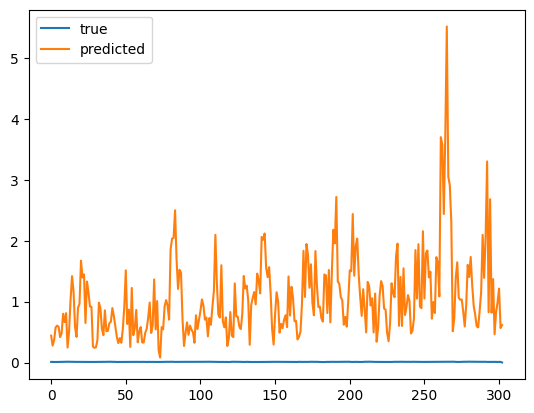

In [51]:
trues=np.array(trues)
preds=np.array(preds)

plt.plot(trues[:,0,0])
plt.plot(np.exp(preds[:,0,0]))
plt.legend(['true', 'predicted'])
plt.show()

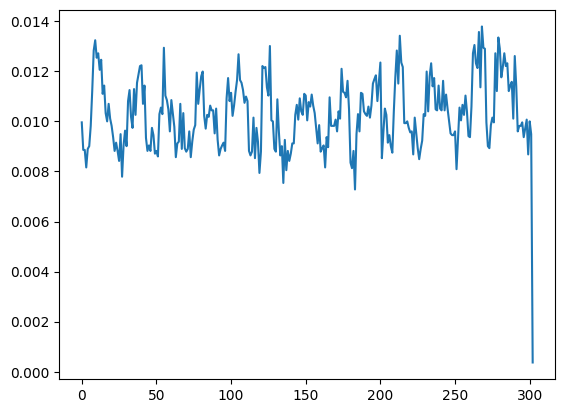

In [52]:
plt.plot(trues[:,0,0])
plt.show()